In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Literal


FILE_PATH = Path('../output/structured_data.xlsx')
df = pd.read_excel(FILE_PATH)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from typing import Literal

def truncate_colormap(cmap, minval=0.25, maxval=1.0, n=256):
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval},{maxval})",
        cmap(np.linspace(minval, maxval, n))
    )

def plot_delta_lines(
    df: pd.DataFrame,
    fungo: str,
    sistema: str = "B",
    *,
    analise: str = "IER",
    concentracoes: list[int] | None = None,
    dias_full: list[int] = [0, 7, 14],
    dias_reduzidos: list[int] = [0, 14],
    figsize_per_col: int = 5,
    show_colorbar: bool = True,
    show_delta: bool = True,
    toxicity_bands: bool = False,
    toxicity_alpha: float = 0.30,
    show_toxicity_legend: bool = True,
    toxicity_legend_position: Literal["top", "bottom"] = "bottom",
):
    """
    Plots side-by-side panels for multiple concentrations:
      - Top row: days 0–7–14
      - Bottom row: days 0–14

    Δ% = (Inoculado₁₄ − Não-inoculado₁₄) / |Não-inoculado₁₄| × 100

    Toxicity bands (IER):
      > 0            Hormese                  → blue
      0 to -0.25     Toxicidade baixa         → green
      -0.25 to -0.5  Toxicidade moderada      → yellow
      -0.5 to -0.75  Toxicidade alta          → orange
      -0.75 to -1.0  Toxicidade muito alta    → red
    """

    # -----------------------------
    # Visual tuning
    # -----------------------------
    LINEWIDTH = 2.2
    MARKERSIZE = 6
    GRID_ALPHA = 0.25
    LABEL_FONTSIZE = 15
    TICK_FONTSIZE = 15
    TITLE_FONTSIZE = 15
    SUPTITLE_FONTSIZE = 18

    sistema_nao_inoculado = sistema
    sistema_inoculado = f"{sistema}I"

    if concentracoes is None:
        concentracoes = [0, 25, 50, 75, 100]

    # Δ colormap: yellow -> blue (no conflict with toxicity bands)
    delta_cmap = plt.get_cmap("cividis")

    # Filter base data once
    df_base = df[
        (df["fungo"].str.contains(fungo, case=False, na=False)) &
        (df["analise"].str.contains(analise, case=False, na=False))
    ].copy()

    def mean_val(conc: int, sist: str, day: int) -> float:
        s = df_base[
            (df_base["concentracao"] == conc) &
            (df_base["sistema"] == sist) &
            (df_base["dia"] == day)
        ]["valor"]
        return float(pd.to_numeric(s, errors="coerce").mean())

    def delta_pct_14(nao_14: float, inoc_14: float) -> float:
        if pd.isna(nao_14) or nao_14 == 0 or pd.isna(inoc_14):
            return np.nan
        return (inoc_14 - nao_14) / abs(nao_14) * 100

    # --------------------------------------------------
    # First pass: Δ% normalization (symmetric around 0)
    # --------------------------------------------------
    deltas_abs: list[float] = []
    for c in concentracoes:
        nao_14 = mean_val(c, sistema_nao_inoculado, 14)
        inoc_14 = mean_val(c, sistema_inoculado, 14)
        d = delta_pct_14(nao_14, inoc_14)
        if pd.notna(d):
            deltas_abs.append(abs(d))

    max_abs_delta = max(deltas_abs) if deltas_abs else 1.0
    norm_delta = mcolors.Normalize(vmin=-max_abs_delta, vmax=max_abs_delta)

    # --------------------------------------------------
    # Figure & layout
    # --------------------------------------------------
    fig_w = figsize_per_col * len(concentracoes) + (1.6 if show_colorbar else 0)
    fig = plt.figure(figsize=(fig_w, 9.5))

    ncols = len(concentracoes) + (1 if show_colorbar else 0)
    width_ratios = [1] * len(concentracoes) + ([0.06] if show_colorbar else [])

    gs = fig.add_gridspec(
        2, ncols,
        width_ratios=width_ratios,
        wspace=0.22,
        hspace=0.28
    )

    axes = np.empty((2, len(concentracoes)), dtype=object)
    for r in range(2):
        for ci in range(len(concentracoes)):
            sharey = axes[0, 0] if (r, ci) != (0, 0) else None
            axes[r, ci] = fig.add_subplot(gs[r, ci], sharey=sharey)

    y_vals: list[float] = []
    system_handles = None

    def draw_delta(ax, nao_14: float, inoc_14: float, d: float, color):
        # vertical delta marker at day 14
        ax.plot([14, 14], [nao_14, inoc_14], color=color, linewidth=4)
        if pd.notna(d):
            ax.text(
                10, (nao_14 + inoc_14) / 2,   # move left of x=14
                f"Δ={d:+.1f}%",
                va="center",
                ha="right",                      # text aligns toward the line
                color=color,
                fontsize=13,
                fontweight="bold",
                bbox=dict(
                    boxstyle="round,pad=0.25",
                    facecolor="white",
                    alpha=0.85,
                    edgecolor="none"
                )
            )

    # --------------------------------------------------
    # Plotting
    # --------------------------------------------------
    for col, conc in enumerate(concentracoes):
        baseline = np.nanmean([
            mean_val(conc, sistema_nao_inoculado, 0),
            mean_val(conc, sistema_inoculado, 0),
        ])

        nao_7 = mean_val(conc, sistema_nao_inoculado, 7)
        inoc_7 = mean_val(conc, sistema_inoculado, 7)
        nao_14 = mean_val(conc, sistema_nao_inoculado, 14)
        inoc_14 = mean_val(conc, sistema_inoculado, 14)

        for v in [baseline, nao_7, inoc_7, nao_14, inoc_14]:
            if pd.notna(v):
                y_vals.append(float(v))

        d = delta_pct_14(nao_14, inoc_14)
        delta_color = "gray" if pd.isna(d) else delta_cmap(norm_delta(d))

        # --- TOP (0–7–14)
        ax_top = axes[0, col]
        l1 = ax_top.plot(
            dias_full, [baseline, nao_7, nao_14],
            marker="o", linewidth=LINEWIDTH, markersize=MARKERSIZE,
            label=sistema_nao_inoculado
        )[0]
        l2 = ax_top.plot(
            dias_full, [baseline, inoc_7, inoc_14],
            marker="o", linewidth=LINEWIDTH, markersize=MARKERSIZE,
            label=sistema_inoculado
        )[0]

        ax_top.axhline(0, color="black", linewidth=1)
        ax_top.set_title(f"{conc}%", fontsize=TITLE_FONTSIZE)
        ax_top.grid(True, alpha=GRID_ALPHA)
        ax_top.tick_params(labelsize=TICK_FONTSIZE)

        if system_handles is None:
            system_handles = [l1, l2]

        if show_delta and pd.notna(nao_14) and pd.notna(inoc_14):
            draw_delta(ax_top, nao_14, inoc_14, d, delta_color)

        # --- BOTTOM (0–14)
        ax_bot = axes[1, col]
        ax_bot.plot(
            dias_reduzidos, [baseline, nao_14],
            marker="o", linewidth=LINEWIDTH, markersize=MARKERSIZE
        )
        ax_bot.plot(
            dias_reduzidos, [baseline, inoc_14],
            marker="o", linewidth=LINEWIDTH, markersize=MARKERSIZE
        )

        ax_bot.axhline(0, color="black", linewidth=1)
        ax_bot.grid(True, alpha=GRID_ALPHA)
        ax_bot.tick_params(labelsize=TICK_FONTSIZE)

        if show_delta and pd.notna(nao_14) and pd.notna(inoc_14):
            draw_delta(ax_bot, nao_14, inoc_14, d, delta_color)

    # --------------------------------------------------
    # Y limits
    # --------------------------------------------------
    if y_vals:
        y_min, y_max = min(y_vals), max(y_vals)
    else:
        y_min, y_max = -1.0, 1.0

    y_min = min(y_min, -1.0)
    margin = (y_max - y_min) * 0.1 if y_max != y_min else 0.5
    y_min -= margin
    y_max += margin

    for ax in axes.ravel():
        ax.set_ylim(y_min, y_max)

    # --------------------------------------------------
    # Toxicity bands
    # --------------------------------------------------
    if toxicity_bands:
        hormesis_top = max(y_max, 0.01)
        bands = [
            ("Hormese (>0)", 0.0, hormesis_top, "#000FFF"),
            ("Toxicidade baixa (0 a -0,25)", -0.25, 0.0, "green"),
            ("Toxicidade moderada (-0,25 a -0,5)", -0.5, -0.25, "yellow"),
            ("Toxicidade alta (-0,5 a -0,75)", -0.75, -0.5, "orange"),
            ("Toxicidade muito alta (-0,75 a -1,0)", -10.0, -0.75, "red"),
        ]
        for ax in axes.ravel():
            for _, y0, y1, color in bands:
                ax.axhspan(y0, y1, color=color, alpha=toxicity_alpha, zorder=0)

    # --------------------------------------------------
    # Labels & title
    # --------------------------------------------------
    axes[0, 0].set_ylabel("Valor médio\n(0–7–14)", fontsize=LABEL_FONTSIZE)
    axes[1, 0].set_ylabel("Valor médio\n(0–14)", fontsize=LABEL_FONTSIZE)
    for ax in axes[1, :]:
        ax.set_xlabel("Dia", fontsize=LABEL_FONTSIZE)

    fig.suptitle(f"{analise} — {fungo} — Sistema {sistema}", fontsize=SUPTITLE_FONTSIZE, fontweight="bold")

    # --------------------------------------------------
    # Legends
    # --------------------------------------------------
    if system_handles:
        fig.legend(
            system_handles,
            [sistema_nao_inoculado, sistema_inoculado],
            title="Sistema",
            loc="upper right",
            frameon=True
        )

    if toxicity_bands and show_toxicity_legend:
        toxicity_handles = [
            Patch(color="blue", label="Hormese (>0)"),
            Patch(color="green", label="Toxicidade baixa"),
            Patch(color="yellow", label="Toxicidade moderada"),
            Patch(color="orange", label="Toxicidade alta"),
            Patch(color="red", label="Toxicidade muito alta"),
        ]
        loc = "upper center" if toxicity_legend_position == "top" else "lower center"
        bbox_y = 1.02 if toxicity_legend_position == "top" else -0.02
        fig.legend(
            handles=toxicity_handles,
            title="Categorias (IER)",
            loc=loc,
            bbox_to_anchor=(0.5, bbox_y),
            ncol=5,
            frameon=True
        )

    # --------------------------------------------------
    # Colorbar (Δ% scale)
    # --------------------------------------------------
    if show_colorbar:
        cax = fig.add_subplot(gs[:, -1])
        sm = cm.ScalarMappable(norm=norm_delta, cmap=delta_cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label("Δ% (Inoculado − Não inoculado)", fontsize=LABEL_FONTSIZE)

    plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal


def plot_heatmap(
    analise: str = "IER",
    *,
    modo: Literal["delta_sistema", "delta_tempo_inoculado"] = "delta_sistema",
    valor_em_porcentagem: bool = True,
    fungi_order: list[str] | None = None,
    figsize: tuple[int, int] = (10, 6),
    annot: bool = True,
):
    """
    Heatmap of deltas (day 14 focus), with two modes:

    modos:
      - "delta_sistema":
            delta A = AI(day14) - A(day14)
            delta B = BI(day14) - B(day14)
            if valor_em_porcentagem=True -> Δ% = (Inoc - Não) / |Não| * 100

      - "delta_tempo_inoculado":
            delta AI = AI(day14) - AI(day0)
            delta BI = BI(day14) - BI(day0)
            if valor_em_porcentagem=True -> Δ% = (14 - 0) / |0| * 100

    Column order:
      delta_sistema:         Δsist A fungus1, Δsist B fungus1, ...
      delta_tempo_inoculado: Δt AI fungus1,  Δt BI fungus1,  ...
    """

    global df  # uses your notebook df; if you prefer, pass df as param

    if fungi_order is None:
        fungi_order = ["Candida", "Saccharomyces", "Aspergillius", "Penicillium"]

    # Keys
    keys_sistema = ["fungo", "concentracao", "dia", "analise"]
    keys_tempo = ["fungo", "concentracao", "analise", "sistema"]  # merge day 14 with day 0

    # Helper: safe % delta
    def pct_delta(num: pd.Series, den: pd.Series) -> pd.Series:
        den_abs = den.abs()
        return np.where(den_abs.ne(0), num * 100 / den_abs, np.nan)

    # -----------------------------
    # Build heatmap_df
    # -----------------------------
    if modo == "delta_sistema":
        df_14 = df[(df["analise"] == analise) & (df["dia"] == 14)].copy()

        df_A  = df_14[df_14["sistema"] == "A"]
        df_AI = df_14[df_14["sistema"] == "AI"]
        df_B  = df_14[df_14["sistema"] == "B"]
        df_BI = df_14[df_14["sistema"] == "BI"]

        mA = df_AI.merge(df_A, on=keys_sistema, suffixes=("_AI", "_A"))
        mB = df_BI.merge(df_B, on=keys_sistema, suffixes=("_BI", "_B"))

        outA = mA[keys_sistema].copy()
        outA["grupo"] = "Δsist A"
        rawA = mA["valor_AI"] - mA["valor_A"]
        outA["valor"] = pct_delta(rawA, mA["valor_A"]) if valor_em_porcentagem else rawA

        outB = mB[keys_sistema].copy()
        outB["grupo"] = "Δsist B"
        rawB = mB["valor_BI"] - mB["valor_B"]
        outB["valor"] = pct_delta(rawB, mB["valor_B"]) if valor_em_porcentagem else rawB

        df_out = pd.concat([outA, outB], ignore_index=True)
        df_out["coluna"] = df_out["grupo"] + " " + df_out["fungo"]

        heatmap_df = (
            df_out.pivot(index="concentracao", columns="coluna", values="valor")
            .sort_index()
        )

        ordered_columns = []
        for f in fungi_order:
            ordered_columns += [f"Δsist A {f}", f"Δsist B {f}"]
        heatmap_df = heatmap_df.reindex(columns=ordered_columns)

        suffix = "%" if valor_em_porcentagem else ""
        title = f"Δ{analise}{suffix} — Delta por sistema (Dia 14)"
        cbar_label = f"Δ{analise}{suffix}"
        annotate_as_percent = bool(valor_em_porcentagem)

    elif modo == "delta_tempo_inoculado":
        df_i = df[
            (df["analise"] == analise) &
            (df["sistema"].isin(["AI", "BI"])) &
            (df["dia"].isin([0, 14]))
        ].copy()

        df_0 = df_i[df_i["dia"] == 0].copy()
        df_14 = df_i[df_i["dia"] == 14].copy()

        m = df_14.merge(df_0, on=keys_tempo, suffixes=("_14", "_0"))

        out = m[keys_tempo].copy()
        out["grupo"] = "Δt"  # time delta
        raw = m["valor_14"] - m["valor_0"]
        out["valor"] = pct_delta(raw, m["valor_0"]) if valor_em_porcentagem else raw

        out["coluna"] = out["sistema"] + " " + out["fungo"]  # AI Candida, BI Candida, ...
        heatmap_df = (
            out.pivot(index="concentracao", columns="coluna", values="valor")
            .sort_index()
        )

        ordered_columns = []
        for f in fungi_order:
            ordered_columns += [f"AI {f}", f"BI {f}"]
        heatmap_df = heatmap_df.reindex(columns=ordered_columns)

        suffix = "%" if valor_em_porcentagem else ""
        title = f"Δ{analise}{suffix} — Delta temporal (Inoculado: Dia 14 − Dia 0)"
        cbar_label = f"Δ{analise}{suffix}"
        annotate_as_percent = bool(valor_em_porcentagem)

    else:
        raise ValueError("modo must be 'delta_sistema' or 'delta_tempo_inoculado'")

    # -----------------------------
    # Plot
    # -----------------------------
    fig, ax = plt.subplots(figsize=figsize)

    data = heatmap_df.values
    if np.isfinite(data).any():
        vmax = np.nanmax(np.abs(data))
        vmax = 1.0 if (vmax == 0 or np.isnan(vmax)) else vmax
    else:
        vmax = 1.0

    vmin = -vmax

    im = ax.imshow(
        data,
        aspect="auto",
        origin="lower",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_xticks(np.arange(len(heatmap_df.columns)))
    ax.set_xticklabels(heatmap_df.columns, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(heatmap_df.index)))
    ax.set_yticklabels(heatmap_df.index)

    ax.set_xlabel("Sistema e fungo")
    ax.set_ylabel("Concentração (%)")
    ax.set_title(title)

    if annot:
        for i in range(len(heatmap_df.index)):
            for j in range(len(heatmap_df.columns)):
                val = heatmap_df.iloc[i, j]
                if pd.notna(val):
                    txt = f"{val:+.1f}%" if annotate_as_percent else f"{val:.2f}"
                    ax.text(j, i, txt, ha="center", va="center", fontsize=9)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    plt.show()


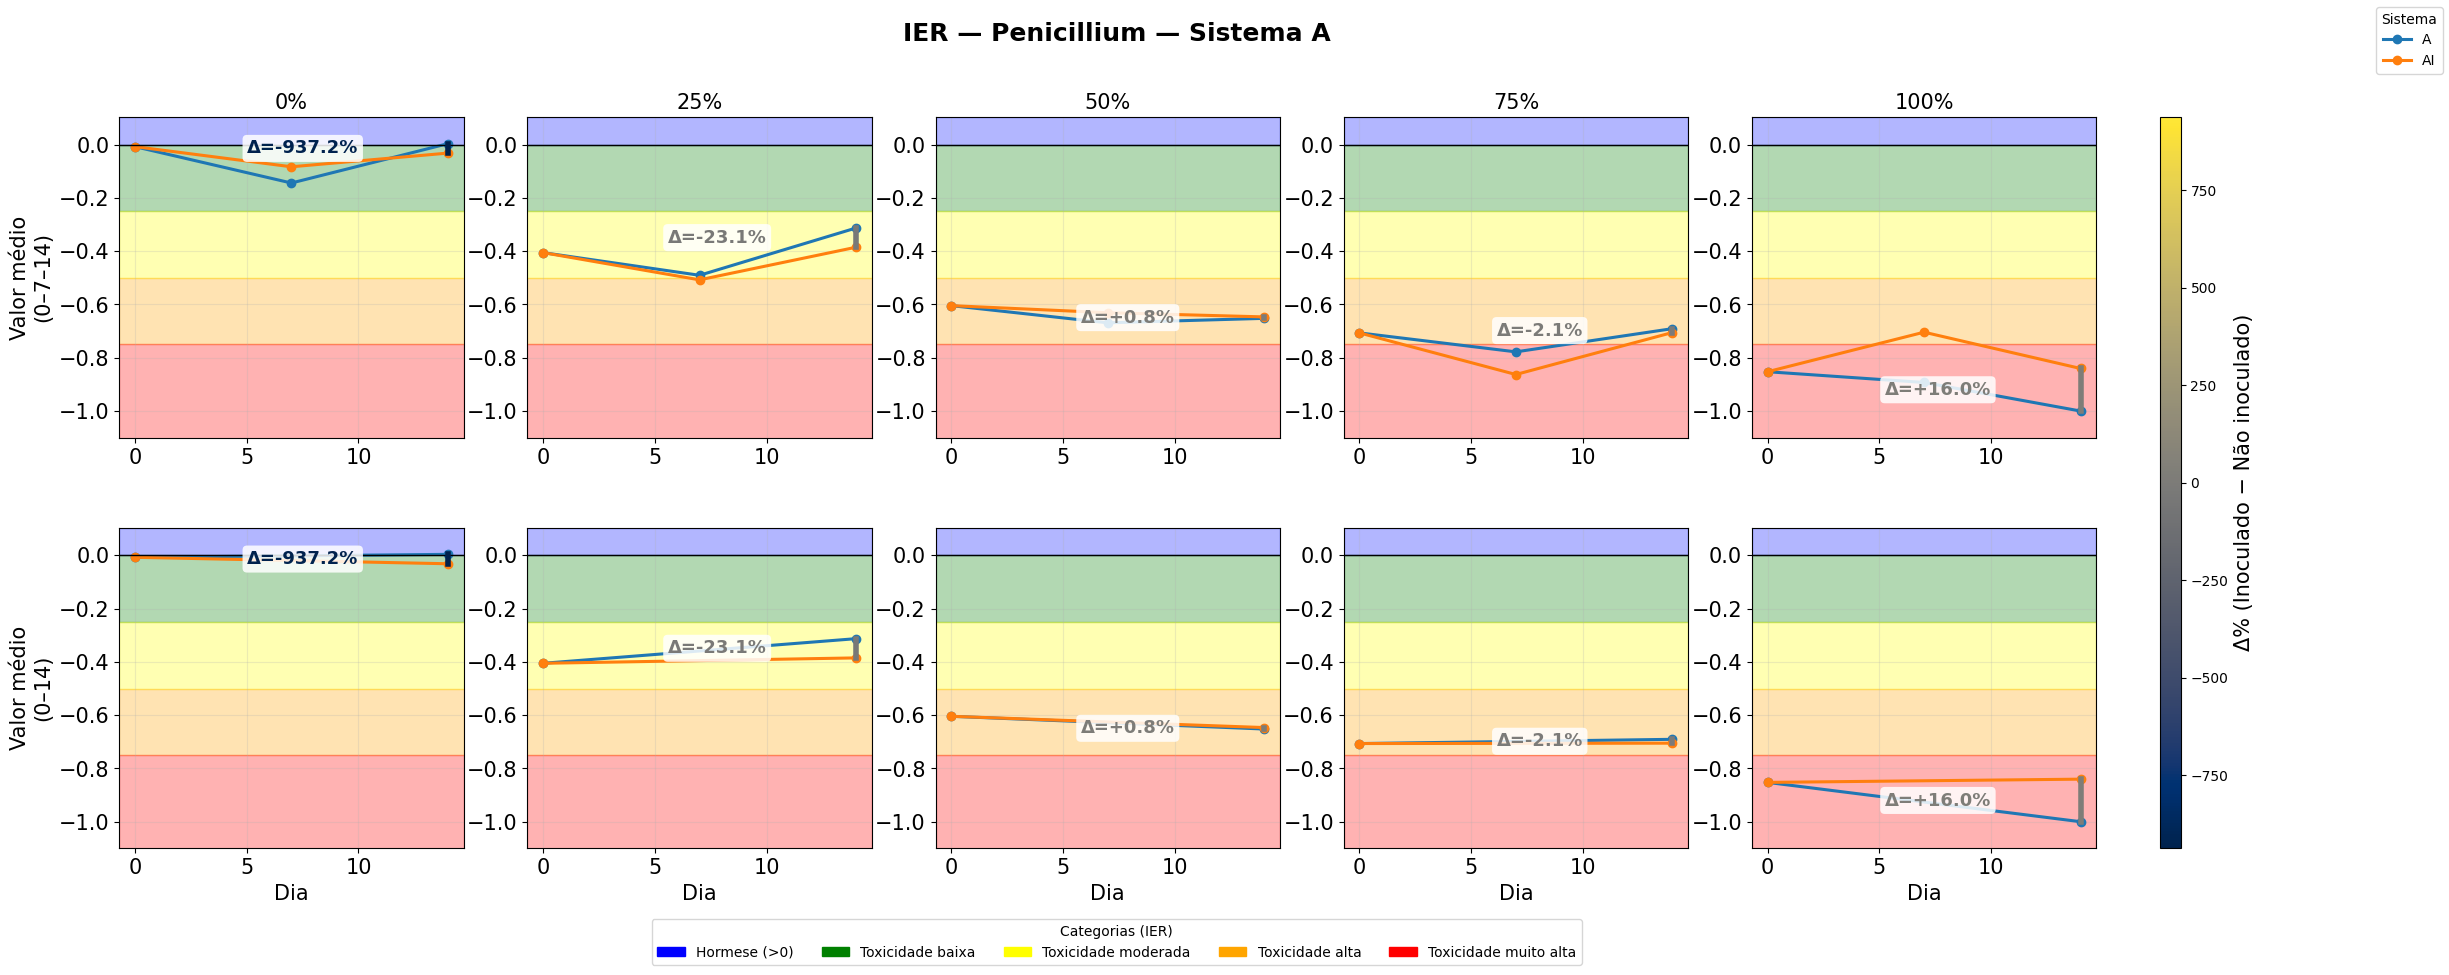

In [21]:
plot_delta_lines(df, fungo="Penicillium", sistema="A", analise="IER", toxicity_bands=True)

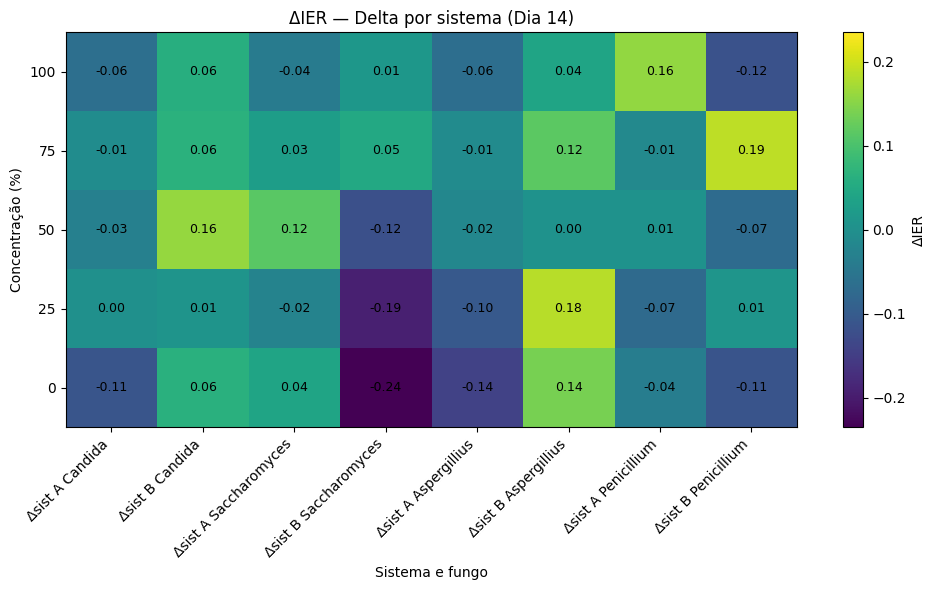

In [8]:
plot_heatmap("IER", modo="delta_sistema", valor_em_porcentagem=False)

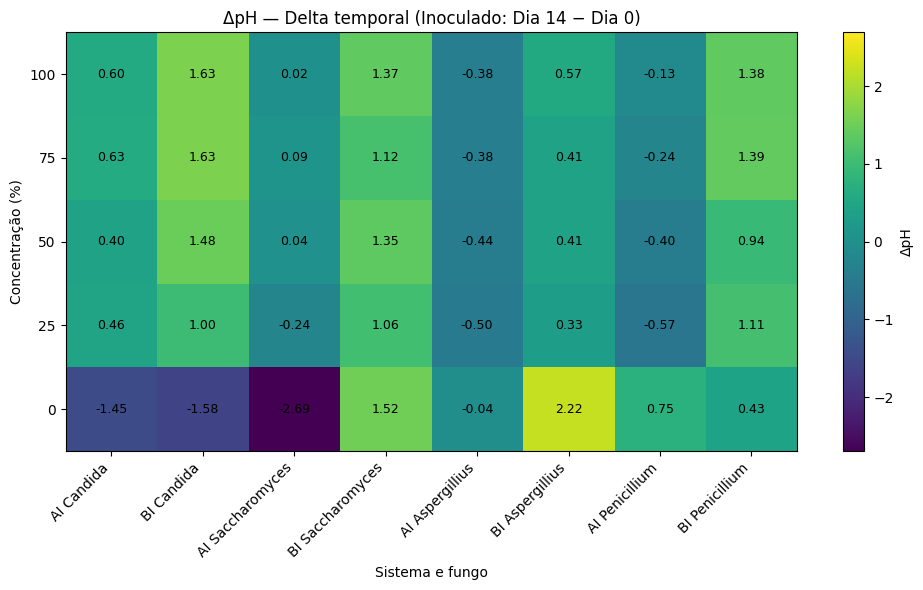

In [6]:
plot_heatmap("pH", modo="delta_tempo_inoculado", valor_em_porcentagem=False)